In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from wrangle import epl_aq_all
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


# Project Goals
1. Create a regression of point differential in predicting future points
2. Analyze the importance of draws in pythagorean expectations predictions
3. Predict by placement (classification) especially on relegation side??

# Wrangle Data
Three functions acquiring and prepping data are all available in wrangle.py file.
- 1. `epl_year_aq`: pulls in data frame from season
- 2. `strip_team_name`: takes in season csv and splits and cleans team_name_column 
- 3. `epl_aq_all`: creates df of all seasons of epl
- 4. `rename columns`: renamess columns explicitly

In [3]:
df = epl_aq_all()

In [4]:
df.to_csv('epl_years.csv')

#### Overview of the dataframe

In [5]:
print(df.shape)
print(df.info())
df.head(2)

(340, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 340 entries, 2002-01-01 to 2018-01-01
Data columns (total 10 columns):
team_name            340 non-null object
games_played         340 non-null int64
wins                 340 non-null int64
draws                340 non-null int64
losses               340 non-null int64
goals_for            340 non-null int64
goals_against        340 non-null int64
goal_differential    340 non-null int64
points               340 non-null int64
place                340 non-null int64
dtypes: int64(9), object(1)
memory usage: 29.2+ KB
None


,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,place
year,,,,,,,,,,
2002-01-01,Manchester United,38,25,8,5,74,34,40,83,1
2002-01-01,Arsenal,38,23,9,6,85,42,43,78,2


In [6]:
df.describe()

,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,place
count,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.00000
mean,38.0,14.235294,9.529412,14.235294,50.758824,50.758824,0.000000,52.208824,10.50000
std,0.0,6.023841,2.819394,5.595820,15.492335,13.182430,25.948667,17.242002,5.77478
min,38.0,1.000000,2.000000,0.000000,20.000000,15.000000,-69.000000,11.000000,1.00000
25%,38.0,10.000000,7.000000,10.000000,41.000000,41.750000,-18.250000,40.000000,5.75000
50%,38.0,13.000000,9.000000,15.000000,47.000000,51.000000,-7.000000,47.500000,10.50000
75%,38.0,18.000000,11.000000,18.000000,59.000000,59.000000,16.500000,63.000000,15.25000
max,38.0,32.000000,17.000000,29.000000,106.000000,89.000000,79.000000,100.000000,20.00000


# Explore

### Team Results

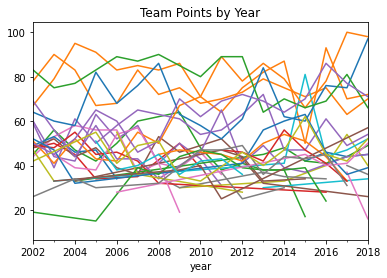

In [11]:
df.groupby('team_name').points.plot()
plt.title('Team Points by Year')
plt.show()

**Takeaways** At the top of the viz, you can see that there are a couple teams that have stayed at the top of the table, but as you get further towards the middle, the data becomes a lot more muddled

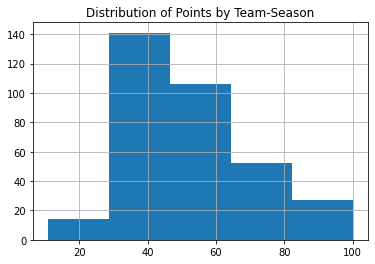

In [23]:
df.points.hist(bins=5)
plt.title("Distribution of Points by Team-Season")
plt.show()

**Takeaways** Looks like a poisson distribution.

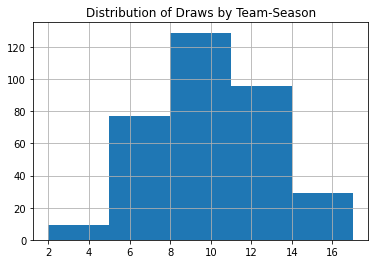

In [22]:
df.draws.hist(bins=5)
plt.title("Distribution of Draws by Team-Season")
plt.show()

**Takeaways** Normal distribution around 9-10 draws per season

In [24]:
df.draws.describe()

count    340.000000
mean       9.529412
std        2.819394
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       17.000000
Name: draws, dtype: float64

Average number of draws per year is 9.5

### Exploring Draws a little more closely

Text(0.5, 1.0, 'Is There a Pattern for Draws by Table Place?')

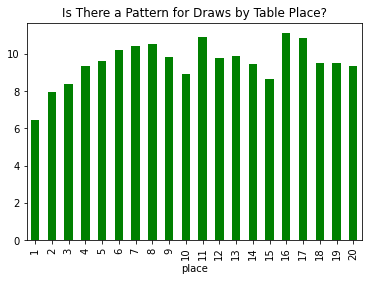

In [29]:
df.groupby('place').draws.mean().plot.bar(color='green')
plt.title('Is There a Pattern for Draws by Table Place?')

**Takeaways** Number of draws tend to be higher at the middle of the table

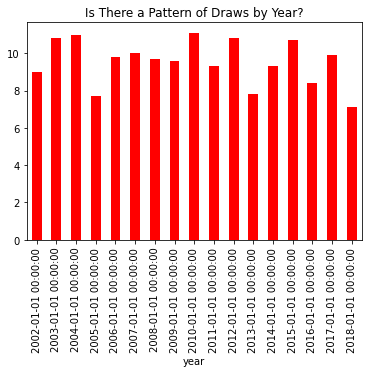

In [32]:
df.groupby('year').draws.mean().plot.bar(color='red')
plt.title('Is There a Pattern of Draws by Year?')
plt.show()

**Takeaways** Not really, there is a pretty significant difference between certain years, but no noticeable trends
**Furtherwork** Some hypothesis testing and statistical analysis

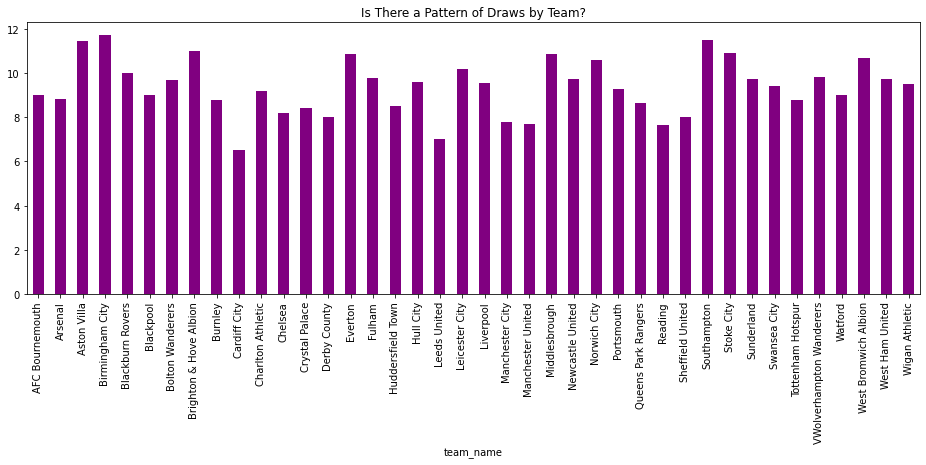

In [43]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.mean().plot.bar(color='purple')
plt.title('Is There a Pattern of Draws by Team?')
plt.show()

**Takeaways** Likely, but not immediately evident.

Text(0.5, 1.0, 'Because of Relegation, How Many Seasons Has Each Team Played?')

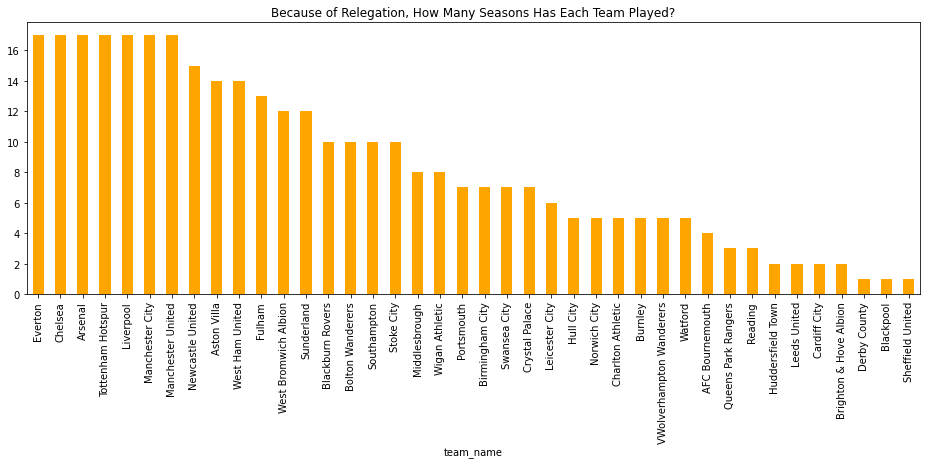

In [44]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.count().sort_values(ascending=False).plot.bar(color='orange')
plt.title('Because of Relegation, How Many Seasons Has Each Team Played?')

### Just for fun , lets look at scatter plots of number of seasons and average number of points and draws!

In [103]:
seasons_series = df.groupby('team_name').draws.count()
seasons_series

team_name
AFC Bournemouth              4
Arsenal                     17
Aston Villa                 14
Birmingham City              7
Blackburn Rovers            10
Blackpool                    1
Bolton Wanderers            10
Brighton & Hove Albion       2
Burnley                      5
Cardiff City                 2
Charlton Athletic            5
Chelsea                     17
Crystal Palace               7
Derby County                 1
Everton                     17
Fulham                      13
Huddersfield Town            2
Hull City                    5
Leeds United                 2
Leicester City               6
Liverpool                   17
Manchester City             17
Manchester United           17
Middlesbrough                8
Newcastle United            15
Norwich City                 5
Portsmouth                   7
Queens Park Rangers          3
Reading                      3
Sheffield United             1
Southampton                 10
Stoke City                  1

In [105]:
df2 = pd.DataFrame(seasons_series)
df2.rename()

,draws
team_name,
AFC Bournemouth,4
Arsenal,17
Aston Villa,14
Birmingham City,7
Blackburn Rovers,10
Blackpool,1
Bolton Wanderers,10
Brighton & Hove Albion,2
Burnley,5


In [72]:
sns.scatterplot(data=df)

ValueError: A wide-form input must have only numeric values.

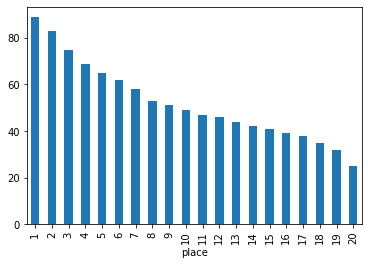

In [54]:
train.groupby('place').points.median().plot.bar()

In [59]:
train[train.points <= 4].points.mean()

nan

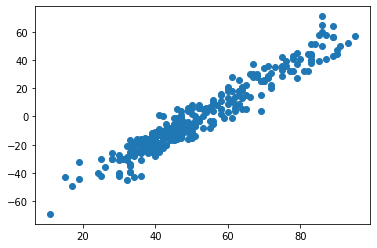

In [69]:
plt.scatter(x='points', y = 'GD', data = train)

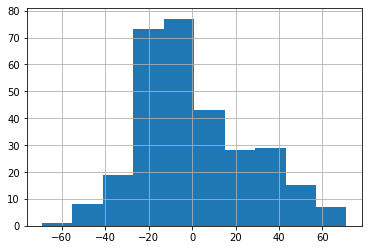

In [80]:
train.GD.hist()

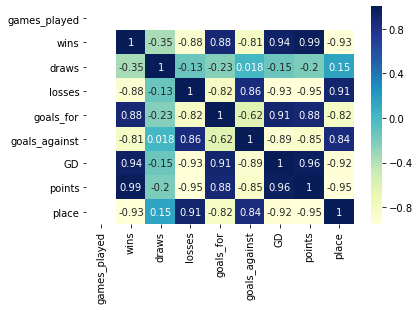

In [90]:
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)

In [92]:
def assing_post_season(df):
    if df.place <= 4:
        df['post_season'] = 'champions_league'
    elif df.place <= 8:
        df['post_season'] = 'europa_league'
    elif df.place <= 14:
        df['post_season'] = 'mid_table'
    elif df.place <= 17:
        df['post_season'] = 'relegation_battle'
    else:
        df['post_season'] = 'relegation'
    return df
    

# train['post_season'] = train.place.apply()

TypeError: apply() missing 1 required positional argument: 'func'

In [93]:
assing_post_season(df)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().